# Recommendation Systems Assignment

### MIE451/1513 UofT

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import scipy 
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from scipy.linalg import sqrtm
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Dense, Activation, Flatten

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=00ecc23a8a0b6a17273814bd0ac16db50a32cee53f2be5d451c3313a9ce653e6
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [4]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [5]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


In [8]:
fields = ['userID', 'itemID', 'rating', 'timestamp']
trainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u1.base'), sep='\t', names=fields)
testDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u1.test'), sep='\t', names=fields)

# test number of records (total should be 100K)
print("# of lines in train:", trainDF.shape[0])
print("# of lines in test:", testDF.shape[0])

# of lines in train: 80000
# of lines in test: 20000


## Q1

### (a)

In [9]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    


    
    
    ###########         end         ###########
    return matrix

In [10]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

In [11]:
dataPreprocessor(rating_df, num_users, num_items).shape

(943, 1682)

### (b)

In [12]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
            # if rating == 0:
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]
                
                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()]
                
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
                
            # report progress every 100 users
            # if (user % 100 == 0 and item == 1):
            #     print ("calculated %d users" % (user,))
    
        


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

                # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            # if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
            # report progress every 100 users
            # if (user % 100 == 0 and item == 1):
            #   print ("calculated %d users" % (user,))
        

                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [13]:
popularity_recsys = BaseLineRecSys('popularity')

In [14]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [15]:
x = popularity_recsys.getModel()

In [16]:
np.all(x<=1)

True

In [17]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [18]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:10, 1410.90it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [19]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [20]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [21]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [22]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:08, 1467.88it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [23]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='euclidean'))
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    

        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='manhattan'))
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########

                temp_matrix = np.zeros(train_matrix.shape)
                temp_matrix[train_matrix.nonzero()] = 1

                uu_similarity = self.method(train_matrix)

                # UxI: UxU mul UxI
                normalizer = np.matmul(uu_similarity, temp_matrix)
                #print(normalizer)
                normalizer[normalizer == 0] = 1e-5
                
                
                predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
                #predictionMatrix[temp_matrix.nonzero()] = 0
                #Cold start
                # if no one has rated this item before, use user average  
                useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
                columns = np.sum(predictionMatrix, axis=0)
                #print(columns.shape)
                predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

                self.__model = predictionMatrix

            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########

            

                temp_matrix= np.zeros(train_matrix.T.shape)
                temp_matrix[train_matrix.T.nonzero()] = 1

                ii_similarity = self.method(train_matrix.T)

                # UxI: UxU mul UxI
                normalizer = np.matmul(ii_similarity, temp_matrix)
                #print(normalizer)
                normalizer[normalizer == 0] = 1e-5
                
                
                predictionMatrix = np.matmul(ii_similarity, train_matrix.T)/normalizer
                #predictionMatrix[temp_matrix.nonzero()] = 0
                #Cold start
                # if no one has rated this item before, use user average  
                useraverage = np.sum(train_matrix.T, axis=1)/np.sum(temp_matrix, axis=1)
                columns = np.sum(predictionMatrix, axis=0)
                #print(columns.shape)
                predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

                self.__model = predictionMatrix.T

            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [24]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [25]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [26]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

- cosine metric works better compared to the Euclidean metric and manhattan metric. As given the identity, matrix cosine predicts the same as the input. As all users have rated different movies, cosine capture this relation perfectly whereas euclidean and manhattan show some similarity between these users which is not the case.

### (b)

- I have chosen manhattan as a third metric. Manhattan is useful when data is very large as it avoids outliers so reduces all errors. 

Reference: https://datascience.stackexchange.com/questions/20075/when-would-one-use-manhattan-distance-as-opposed-to-euclidean-distance

## Q3

### (a)

In [27]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [28]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [29]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [30]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [31]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:22, 1213.55it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


### (b)

In [32]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [33]:
# How to use CrossValidation Class?

In [34]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys]

In [35]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('P@K')

In [36]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity


20000it [00:06, 2967.68it/s]
20000it [00:06, 3133.00it/s]
20000it [00:06, 3161.86it/s]
20000it [00:06, 3185.57it/s]
20000it [00:06, 3071.29it/s]


Processing algorithm useraverage


20000it [00:06, 3224.42it/s]
20000it [00:06, 3189.15it/s]
20000it [00:06, 3210.52it/s]
20000it [00:06, 3165.85it/s]
20000it [00:06, 3161.86it/s]


Processing algorithm user-cosine


20000it [00:06, 3118.20it/s]
20000it [00:06, 3130.10it/s]
20000it [00:06, 3188.06it/s]
20000it [00:06, 3118.99it/s]
20000it [00:06, 3131.71it/s]


{'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

In [37]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
user_cosine_recsys = SimBasedRecSys('user','cosine')
cv_rmse = CrossValidation('RMSE')
algorithm_instances = [user_cosine_recsys,item_cosine_recsys ]
rmse_data_3 = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

rmse_df_3 = pd.DataFrame(rmse_data_3, index = ["CI","mean","min","max"])
rmse_df_3

Processing algorithm user-cosine


20000it [00:06, 3113.45it/s]
20000it [00:06, 3100.45it/s]
20000it [00:06, 3090.48it/s]
20000it [00:06, 3127.55it/s]
20000it [00:06, 3095.61it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3173.83it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3108.08it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3101.23it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3044.88it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3158.17it/s]


,user-cosine,item-cosine
CI,"[1.026449013124381, 1.0214387664779507, 1.0132...","[1.0377631264364244, 1.0207280585350078, 1.010..."
mean,1.01735,1.02008
min,1.00901,1.00682
max,1.0257,1.03334


- User - user works better than item-item as in user user similarity, users with more similar preference get more similarity and prediction based on the same preference yields better results whereas in item-item, we consider only items similarity. In that case it might be a possibility that one user loves one particular genre but he/she does not like all the movies lie in that genre. So user user gives better predictions.

## Q4

### (a)

In [38]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = np.sqrt(0.1) * np.random.randn(num_item , self.num_feat)  # item M x D 
        self.w_User = np.sqrt(0.1) * np.random.randn(num_user , self.num_feat)  # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID] , self.w_Item[batch_ItemID]), axis= 1 ) #size (batch_size, )
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx] , self.w_Item[train_item_idx]), axis= 1 ) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx] , self.w_Item[val_item_idx]), axis= 1 ) #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [78]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

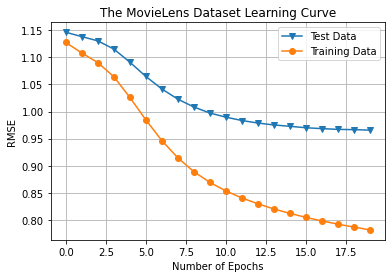

In [77]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

- After 17 epochs, test data starts overfitting.

## Q5

### (a)

In [41]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [42]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,item_cosine_recsys,pmf]


In [43]:
cv_rmse = CrossValidation('RMSE')
cv_patk = CrossValidation('P@K')
cv_rp = CrossValidation('RPrecision')

In [44]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
rmse_data = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)
patk_data = cv_patk.run(algorithm_instances, num_users, num_items,k=5)
rp_data = cv_rp.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity


20000it [00:06, 3083.84it/s]
20000it [00:06, 3131.83it/s]
20000it [00:06, 3192.67it/s]
20000it [00:06, 3112.30it/s]
20000it [00:06, 3151.54it/s]


Processing algorithm useraverage


20000it [00:06, 3151.77it/s]
20000it [00:06, 3210.91it/s]
20000it [00:06, 3177.52it/s]
20000it [00:06, 3231.58it/s]
20000it [00:06, 3190.60it/s]


Processing algorithm user-cosine


20000it [00:06, 3096.80it/s]
20000it [00:06, 3098.14it/s]
20000it [00:06, 3154.93it/s]
20000it [00:06, 3128.15it/s]
20000it [00:06, 3137.70it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3102.90it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3108.60it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3124.01it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3084.86it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3072.24it/s]


Processing algorithm PMF


20000it [00:11, 1684.72it/s]
20000it [00:11, 1701.23it/s]
20000it [00:11, 1693.68it/s]
20000it [00:11, 1680.18it/s]
20000it [00:11, 1707.66it/s]


Processing algorithm popularity


20000it [00:06, 3148.46it/s]
20000it [00:06, 3219.86it/s]
20000it [00:06, 3146.92it/s]
20000it [00:06, 3165.01it/s]
20000it [00:06, 3163.93it/s]


Processing algorithm useraverage


20000it [00:06, 3154.95it/s]
20000it [00:06, 3154.06it/s]
20000it [00:06, 3115.31it/s]
20000it [00:06, 3128.00it/s]
20000it [00:06, 3140.98it/s]


Processing algorithm user-cosine


20000it [00:06, 3106.18it/s]
20000it [00:06, 3018.11it/s]
20000it [00:06, 3130.95it/s]
20000it [00:06, 3142.78it/s]
20000it [00:06, 3138.58it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3128.84it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3069.85it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3129.71it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3131.50it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3093.75it/s]


Processing algorithm PMF


20000it [00:11, 1696.56it/s]
20000it [00:11, 1710.88it/s]
20000it [00:11, 1694.31it/s]
20000it [00:11, 1713.44it/s]
20000it [00:11, 1675.55it/s]


Processing algorithm popularity


20000it [00:06, 3161.44it/s]
20000it [00:06, 3178.49it/s]
20000it [00:06, 3126.41it/s]
20000it [00:06, 3182.47it/s]
20000it [00:06, 3190.77it/s]


Processing algorithm useraverage


20000it [00:06, 3180.72it/s]
20000it [00:06, 3154.87it/s]
20000it [00:06, 3187.80it/s]
20000it [00:06, 3135.93it/s]
20000it [00:06, 3214.75it/s]


Processing algorithm user-cosine


20000it [00:06, 3187.74it/s]
20000it [00:06, 3178.60it/s]
20000it [00:06, 3111.82it/s]
20000it [00:06, 3163.70it/s]
20000it [00:06, 3154.29it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3099.76it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3156.85it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3164.23it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3142.91it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3136.34it/s]


Processing algorithm PMF


20000it [00:11, 1710.77it/s]
20000it [00:11, 1717.00it/s]
20000it [00:11, 1705.02it/s]
20000it [00:11, 1720.44it/s]
20000it [00:17, 1169.05it/s]


In [45]:
rmse_df = pd.DataFrame(rmse_data, index = ["CI","mean","min","max"])
rmse_df

,popularity,useraverage,user-cosine,item-cosine,PMF
CI,"[3.177941281084362, 3.1750480150769977, 3.1474...","[1.0629951276561334, 1.0467467492319966, 1.032...","[1.026449013124381, 1.0214387664779507, 1.0132...","[1.0377631264364244, 1.0207280585350078, 1.010...","[0.9877282816850255, 0.972251768241819, 0.9582..."
mean,3.15909,1.04372,1.01735,1.02008,0.966076
min,3.13929,1.02893,1.00901,1.00682,0.948869
max,3.17889,1.0585,1.0257,1.03334,0.983284


In [46]:
patk_df = pd.DataFrame(patk_data, index = ["CI","mean","min","max"])
patk_df

,popularity,useraverage,user-cosine,item-cosine,PMF
CI,"[0.36924708377518656, 0.4965005302226948, 0.61...","[0.30604453870625714, 0.4305408271474029, 0.53...","[0.37179215270413657, 0.503923647932133, 0.621...","[0.34316012725344736, 0.483563096500532, 0.602...","[0.36161187698833597, 0.5013785790031828, 0.62..."
mean,0.550583,0.473637,0.555843,0.532216,0.548123
min,0.405441,0.341999,0.409598,0.383701,0.402177
max,0.695725,0.605275,0.702088,0.680732,0.694069


In [47]:
rp_df = pd.DataFrame(rp_data, index = ["CI","mean","min","max"])
rp_df

,popularity,useraverage,user-cosine,item-cosine,PMF
CI,"[0.7177873723889607, 0.7070154178036713, 0.712...","[0.6403680886295169, 0.6452698039088018, 0.641...","[0.7177834541075783, 0.7127674206396806, 0.715...","[0.6999034077107555, 0.7051212779090774, 0.713...","[0.6990441186620084, 0.7045971446006261, 0.709..."
mean,0.717666,0.64573,0.721019,0.708014,0.707049
min,0.706824,0.639631,0.709995,0.700692,0.699853
max,0.728509,0.65183,0.732042,0.715336,0.714246


### (b)

- RMSE measure is not an ideal choice for evaluating popularity based recommendation system. The data points contain only 0 and 1 whereas RMSE is more useful for regression datapoints. Actual ratings are between 0-5. So in this case RMSE is not useful. 
- P@k and R-precision measures are not useful for useraverage evaluation because all non-rated fields imputed with average of particular user ratings. So in that case judging the system based on the ranking of the recommendations is not the best option. 

### (c)
- PMF(RMSE - 0.98) is the best algorithm for RMSE. As predictions are made by minimizing errors through gradient descent. 
- user-cosine (P@k - 0.70 and R-P - 0.73) algorithm is best for P@k and R-Precision as it captures the relevance of the ranking based on the user-user similarity.

### (d)
- Good peformance of RMSE does imply good performnce on ranking metrics as RMSE captures difference between true and predicted values. So ranking would be better if rmse is good. But if ranking is good that does not mean rmse is good as ranking evaluation can be done with p@k and r@k. 

## Q6

### (a)

In [48]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
#pd.set_option("display.max_rows", None, "display.max_columns", None)
titles = moviesDF.movieTitle

titles

0                                Toy Story (1995)
1                                GoldenEye (1995)
2                               Four Rooms (1995)
3                               Get Shorty (1995)
4                                  Copycat (1995)
                          ...                    
1677                            Mat' i syn (1997)
1678                             B. Monkey (1998)
1679                         Sliding Doors (1998)
1680                          You So Crazy (1994)
1681    Scream of Stone (Schrei aus Stein) (1991)
Name: movieTitle, Length: 1682, dtype: object

In [49]:
item_matrix = dataPreprocessor(rating_df, num_users, num_items).T
item_similarity = 1 - pairwise_distances(item_matrix, metric='cosine')
item_similarity_df = pd.DataFrame(item_similarity, columns = titles, index = titles)
item_similarity_df.head()

movieTitle,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),Seven (Se7en) (1995),"Usual Suspects, The (1995)",Mighty Aphrodite (1995),"Postino, Il (1994)",Mr. Holland's Opus (1995),French Twist (Gazon maudit) (1995),From Dusk Till Dawn (1996),"White Balloon, The (1995)",Antonia's Line (1995),Angels and Insects (1995),Muppet Treasure Island (1996),Braveheart (1995),Taxi Driver (1976),Rumble in the Bronx (1995),"Birdcage, The (1996)","Brothers McMullen, The (1995)",Bad Boys (1995),Apollo 13 (1995),Batman Forever (1995),Belle de jour (1967),Crimson Tide (1995),Crumb (1994),Desperado (1995),"Doom Generation, The (1995)",Free Willy 2: The Adventure Home (1995),Mad Love (1995),Nadja (1994),"Net, The (1995)",Strange Days (1995),"To Wong Foo, Thanks for Everything! Julie Newmar (1995)",...,Angel Baby (1995),Sudden Manhattan (1996),"Butcher Boy, The (1998)",Men With Guns (1997),Hana-bi (1997),"Niagara, Niagara (1997)","Big One, The (1997)","Butcher Boy, The (1998)","Spanish Prisoner, The (1997)",Temptress Moon (Feng Yue) (1996),Entertaining Angels: The Dorothy Day Story (1996),Chairman of the Board (1998),"Favor, The (1994)",Little City (1998),Target (1995),"Substance of Fire, The (1996)",Getting Away With Murder (1996),Small Faces (1995),"New Age, The (1994)",Rough Magic (1995),Nothing Personal (1995),8 Heads in a Duffel Bag (1997),"Brother's Kiss, A (1997)",Ripe (1996),"Next Step, The (1995)",Wedding Bell Blues (1996),MURDER and murder (1996),Tainted (1998),"Further Gesture, A (1996)",Kika (1993),Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
movieTitle,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,0.468291,0.460392,0.417509,0.347678,0.574377,0.224120,0.273916,0.046232,0.191772,0.232930,0.339196,0.527169,0.338105,0.467598,0.567950,0.227295,0.208472,0.592877,0.361657,0.150959,0.439441,0.259257,0.288536,0.090654,0.136757,0.108560,0.069805,0.368420,0.278386,0.246123,...,0.065390,0.010550,0.023592,0.014155,0.023592,0.023592,0.023592,0.023592,0.023592,0.014226,0.0,0.058979,0.047183,0.032856,0.035387,0.048189,0.058979,0.058979,0.035387,0.0,0.0,0.067404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033363,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
GoldenEye (1995),0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,0.468506,0.459946,0.213972,0.125463,0.253162,0.098185,0.390438,0.113063,0.030692,0.091550,0.319308,0.483349,0.278182,0.434907,0.306639,0.206481,0.408737,0.483077,0.581119,0.089355,0.462797,0.160738,0.479187,0.072342,0.087347,0.215247,0.184592,0.562970,0.334570,0.256668,...,0.049324,0.035017,0.078299,0.046980,0.078299,0.078299,0.078299,0.078299,0.078299,0.000000,0.0,0.000000,0.078299,0.000000,0.104399,0.000000,0.000000,0.000000,0.104399,0.0,0.0,0.074571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055366,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
Four Rooms (1995),0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,0.361165,0.319295,0.271402,0.190242,0.266335,0.167609,0.404239,0.126564,0.105377,0.187733,0.194546,0.293732,0.233814,0.381910,0.306447,0.214125,0.261303,0.269296,0.253074,0.126347,0.259129,0.185187,0.404930,0.179008,0.046315,0.073332,0.051270,0.240534,0.277311,0.176729,...,0.036615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009736,0.0,0.000000,0.096875,0.000000,0.000000,0.000000,0.064583,0.064583,0.096875,0.0,0.0,0.018452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0

In [50]:
movies = ["Pollyanna (1960)", "Touch (1997)", "Story of Xinghua, The (1993)"]

for name in movies:
  print("Similar movies to ", name, ":")

  index = np.argsort(item_similarity_df[name].values)[-6:-1]
  print( item_similarity_df[name][index])
  print("\n")
  print("-------------------------------------------------")

Similar movies to  Pollyanna (1960) :
movieTitle
Pinocchio (1940)                   0.376296
Mary Poppins (1964)                0.390342
Apple Dumpling Gang, The (1975)    0.410328
Shaggy Dog, The (1959)             0.417363
Parent Trap, The (1961)            0.432372
Name: Pollyanna (1960), dtype: float64


-------------------------------------------------
Similar movies to  Touch (1997) :
movieTitle
Bloody Child, The (1996)              0.351123
Power 98 (1995)                       0.351123
Great Day in Harlem, A (1994)         0.351123
Object of My Affection, The (1998)    0.351123
Portrait of a Lady, The (1996)        0.383143
Name: Touch (1997), dtype: float64


-------------------------------------------------
Similar movies to  Story of Xinghua, The (1993) :
movieTitle
Rendezvous in Paris (Rendez-vous de Paris, Les) (1995)    0.502625
Neon Bible, The (1995)                                    0.533333
Mina Tannenbaum (1994)                                    0.540222
I Can't Sle

### (b)
- The first movie that I selected is "Pollyanna", and the similarities are perfect as all the movies lie in one genre(kids, family and comedy).
- For second choice also, the recommendations have one common quality that they are based on love and romance. So most likely users who love to watch romantic genre, have rated these movies.
- Third choice is more like of drama genre and two of them are chinese movies. So people who love to watch chinese movies have rated them. 

## Q7

### (a)

Text(0.5, 1.0, 'User vs No. of ratings plot')

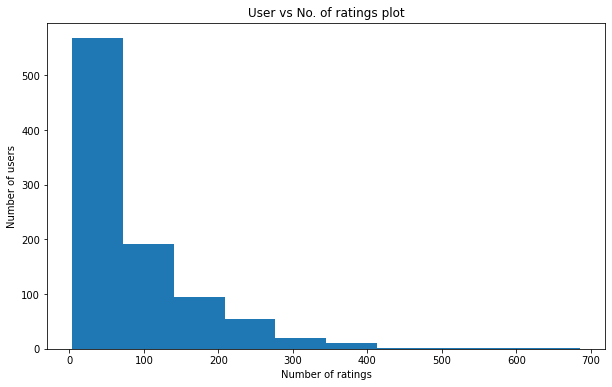

In [51]:
rating_count = trainDF.userID.value_counts().tolist()
plt.figure(figsize = (10,6))
plt.hist(rating_count)
plt.xlabel("Number of ratings")
plt.ylabel("Number of users")
plt.title("User vs No. of ratings plot")





In [52]:
# thresold

t = 60
### train split
n_rating_df = pd.DataFrame(rating_df.userID.value_counts())

above_t_df_train = n_rating_df[ n_rating_df.userID.values >= t ] 
below_t_df_train = n_rating_df[ n_rating_df.userID.values < t ] 

below_df_train = trainDF[trainDF["userID"].isin(below_t_df_train.index)]
below_df_train = below_df_train.reset_index(drop=True)

above_df_train = trainDF[trainDF["userID"].isin(above_t_df_train.index)]
above_df_train = above_df_train.reset_index(drop=True)


# test split

above_t_df_test = n_rating_df[ n_rating_df.userID.values >= t ] 

below_t_df_test = n_rating_df[ n_rating_df.userID.values < t ] 



below_df_test = testDF[testDF["userID"].isin(below_t_df_test.index)]
below_df_test = below_df_test.reset_index(drop=True)

above_df_test = testDF[testDF["userID"].isin(above_t_df_test.index)]
above_df_test = above_df_test.reset_index(drop=True)

In [53]:
user_cosine_above = SimBasedRecSys('user','cosine')
user_cosine_above.predict_all(above_df_train, num_users, num_items)

user_cosine_below = SimBasedRecSys('user','cosine')
user_cosine_below.predict_all(below_df_train, num_users, num_items)

item_cosine_above = SimBasedRecSys('item','cosine')
item_cosine_above.predict_all(above_df_train, num_users, num_items)

item_cosine_below = SimBasedRecSys('item','cosine')
item_cosine_below.predict_all(below_df_train, num_users, num_items)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


In [54]:
user_pred_above = user_cosine_above.evaluate_test(above_df_test,copy=True)
user_pred_below = user_cosine_below.evaluate_test(below_df_test,copy=True)
item_pred_above = item_cosine_above.evaluate_test(above_df_test,copy=True)
item_pred_below = item_cosine_below.evaluate_test(below_df_test,copy=True)

17110it [00:05, 3222.65it/s]
2890it [00:00, 3003.12it/s]
17110it [00:05, 3198.93it/s]
2890it [00:00, 3291.24it/s]


In [55]:
item_rmse_above = CrossValidation.rmse(item_pred_above, 5, num_users, num_items, pred="item-cosine", true='rating')
item_rmse_below = CrossValidation.rmse(item_pred_below, 5, num_users, num_items, pred="item-cosine", true='rating')
user_rmse_above = CrossValidation.rmse(user_pred_above, 5, num_users, num_items, pred="user-cosine", true='rating')
user_rmse_below = CrossValidation.rmse(user_pred_below, 5, num_users, num_items, pred="user-cosine", true='rating')

print("item-item RMSE value for above thresold rated items is:" , item_rmse_above )
print("item-item RMSE value for below thresold rated items is:" , item_rmse_below )
print("user-user RMSE value for above thresold rated items is:" , user_rmse_above )
print("user-user RMSE value for below thresold rated items is:" , user_rmse_below )

item-item RMSE value for above thresold rated items is: 1.0414573747283948
item-item RMSE value for below thresold rated items is: 1.1692417179982133
user-user RMSE value for above thresold rated items is: 1.0222508500700602
user-user RMSE value for below thresold rated items is: 1.0856180547940522


- In user-user, the above threshold rmse is low compared to below threshold value. As above threshold users have rated more items compared to below threshold so, more data points in a fewer number of users give a better prediction.
- And the same goes for item-item rmse values. 
- We can observe that user user rmse is lower than item item which is logically justifiable.

## Q8

In [56]:
class CompetitionRecSys(object):
    """
    You can define new methods if you need. Don't use global variables in the class. 
    """
    def __init__(self, pred_column_name):
        """
        Initialization of the class
        1. Make sure to fill out self.pred_column_name, the name you give  to your competition method
        
        """
        ########## your code goes here ###########
        self.pred_column_name = "avg"

        ###########         end         ###########

    def predict_all(self, train_vec, num_user, num_item):
        """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            num_user: scalar. number of users
            num_item: scalar. number of items
        OUTPUT:
            no return... 
        
        NOTES:
            This function is where you train your model
        
        """
        matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
        # Populate the matrix based on the dataset
        for (index, userID, itemID, rating, timestamp) in train_vec.itertuples():
            matrix[userID-1, itemID-1] = rating


        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')

        train_matrix = matrix
        
        
            ########### your code goes here ###########

        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1

        uu_similarity = similarity_matrix

                # UxI: UxU mul UxI
        normalizer = np.matmul(uu_similarity, temp_matrix)
                #print(normalizer)
        normalizer[normalizer == 0] = 1e-5
                
                
        uu_predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
                #predictionMatrix[temp_matrix.nonzero()] = 0
                #Cold start
                # if no one has rated this item before, use user average  
        useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
        columns = np.sum(uu_predictionMatrix, axis=0)
                #print(columns.shape)
        uu_predictionMatrix[:, columns==0] = uu_predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)




        ########################################### for item-item #####################################################

        temp_matrix_ii= np.zeros(train_matrix.T.shape)
        temp_matrix_ii[train_matrix.T.nonzero()] = 1

        ii_similarity = 1 - pairwise_distances(matrix.T, metric='cosine')

                # UxI: UxU mul UxI
        normalizer_ii = np.matmul(ii_similarity, temp_matrix_ii)
                #print(normalizer)
        normalizer_ii[normalizer_ii == 0] = 1e-5
                
                
        ii_predictionMatrix = np.matmul(ii_similarity, train_matrix.T)/normalizer_ii
                #predictionMatrix[temp_matrix.nonzero()] = 0
                #Cold start
                # if no one has rated this item before, use user average  
        useraverage_ii = np.sum(train_matrix.T, axis=1)/np.sum(temp_matrix_ii, axis=1)
        columns = np.sum(ii_predictionMatrix, axis=0)
                #print(columns.shape)
        ii_predictionMatrix[:, columns==0] = ii_predictionMatrix[:, columns==0] + np.expand_dims(useraverage_ii, axis=1)

        ii_predictionMatrix = ii_predictionMatrix.T

        ###########         end         ###########

        self.__model1 =  uu_predictionMatrix
        self.__model2 = ii_predictionMatrix

        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTES:
            This function is where your model makes prediction 
            Please fill out: prediction.loc[index, self.pred_column_name] = None                            
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            ########### your code goes here ###########
            prediction.loc[index, self.pred_column_name] = (0.50*self.__model1[userID-1, itemID-1]) + (0.50*self.__model2[userID-1, itemID-1])
            # prediction.loc[index, self.pred_column_name] = self.__model[userID-1,itemID-1]
            ###########         end         ###########

        return prediction
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        ########### your code goes here ###########
        try:
            self.model1 = None
            self.model2 = None 
        except:
            print("You do not have model..")

        ##########         end         ###########


In [57]:
competition = CompetitionRecSys("avg")
algorithm_instances = [competition]
cv_rp = CrossValidation('RPrecision')
rp = cv_rp.run(algorithm_instances, num_users, num_items)

Processing algorithm avg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 2931.93it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 2983.45it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3193.65it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3141.01it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3029.09it/s]


In [58]:
rp

{'avg': [[0.7220711634390354,
   0.7192014664038138,
   0.7267301503407226,
   0.7265725433847029,
   0.7415002647818093],
  0.7272151176700168,
  0.7165448884725899,
  0.7378853468674437]}

### Final rp  = 0.7272

- I have used the weighted average of the user-user and item-item similarity-based prediction. Giving more weightage to user-user similarity yields in comparatively good R-precision. 

# Validation

In [59]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [60]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [61]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [62]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [63]:
validatePopularityRecSys()

### User Average Based Recommendation

In [64]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [65]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [66]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [67]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [68]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [69]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [70]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [71]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [72]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        item_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        item_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = item_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [73]:
validateIISimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [74]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [75]:
validatePMFRecSys(validation_df=validation_df)